In [48]:
import pandas as pd
import numpy as np
from scipy.special import softmax
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# 读你的总表
df = pd.read_excel("model_variables.xlsx")   # 或 read_csv，看你存的格式

item_list = [
    'Purple','Blue','Green','Red','Orange',
    'Risk','Hope','Safety','Vitality','Power',
    'Literature','Physics','Music','History',
    'Geography','Sea','Desert','City','Mountain','Village'
]

df["Disappointment"] = df["Disappointment"].fillna(0)
df["Regret"] = df["Regret"].fillna(0)

# 只保留有有效选择的 trial
df = df[df["Choice_itemName"].notna()]
df = df[df["Choice_itemName"] != 0]

# 把选项名字标准化成和 item_list 一致的格式
df["Choice_itemName"] = df["Choice_itemName"].astype(str).str.strip().str.title()

df


,User,Trial,Choice_itemID,Choice_itemName,Choice_category,Pref_Purple,Pref_Blue,Pref_Green,Pref_Red,Pref_Orange,...,RPE_City,EV_Mountain,Var_Mountain,RPE_Mountain,EV_Village,Var_Village,RPE_Village,Regret,Disappointment,Uncertainty
0,1,1,7.0,Hope,Abstract,3,4,2,2,3,...,NaN,0.00,1.000,NaN,0.00,1.000,NaN,1.0,0.000000,0.263158
1,1,2,9.0,Vitality,Abstract,3,4,2,2,3,...,NaN,0.00,1.000,NaN,0.00,1.000,NaN,0.0,-1.000000,0.357143
2,1,3,12.0,Physics,Disciplines,3,4,2,2,3,...,NaN,0.00,1.000,NaN,0.00,1.000,NaN,0.0,-0.500000,0.357143
3,1,4,16.0,Sea,Places,3,4,2,2,3,...,NaN,0.00,1.000,NaN,0.00,1.000,NaN,0.0,1.666667,0.192308
4,1,5,13.0,Music,Disciplines,3,4,2,2,3,...,NaN,0.00,1.000,NaN,0.00,1.000,NaN,0.0,-0.750000,0.357143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,26,36,10.0,Power,Abstract,1,1,1,1,1,...,NaN,1.23,3.042,NaN,0.90,2.800,NaN,0.0,0.291714,0.253036
1036,26,37,1.0,Purple,Color,1,1,1,1,1,...,NaN,1.23,3.042,NaN,0.90,2.800,NaN,0.0,0.163611,0.258286
1037,26,38,6.0,Risk,Abstract,1,1,1,1,1,...,NaN,1.23,3.042,NaN,0.90,2.800,NaN,0.0,-0.650811,0.195535
1038,26,39,16.0,Sea,Places,1,1,1,1,1,...,NaN,1.23,3.042,NaN,0.90,2.800,NaN,0.0,-2.311684,0.150435


In [49]:
# 自动抽取所有 item 名称
item_list = sorted([
    col.replace("Pref_", "") 
    for col in df.columns 
    if col.startswith("Pref_")
])

print("Total items:", len(item_list))
print(item_list)

Total items: 20
['Blue', 'City', 'Desert', 'Geography', 'Green', 'History', 'Hope', 'Literature', 'Mountain', 'Music', 'Orange', 'Physics', 'Power', 'Purple', 'Red', 'Risk', 'Safety', 'Sea', 'Village', 'Vitality']


In [50]:

# 对所有特征进行标准化
from sklearn.preprocessing import StandardScaler

def standardize_features(df, user_col='User'):
    """
    修复版本: Preference不标准化(保留原始值)
    """
    
    scaled_df = df.copy()
    
    # 只标准化这些动态特征,不标准化Pref!
    dynamic_features = ['EV', 'Var', 'Regret', 'Dis', 'Unc']
    
    # 找出所有需要标准化的列
    feature_columns = []
    pref_columns = []
    
    for col in df.columns:
        # Pref列单独处理
        if col.startswith('Pref_'):
            pref_columns.append(col)
        else:
            # 其他特征正常标准化
            for feat in dynamic_features:
                if col.startswith(f"{feat}_"):
                    feature_columns.append(col)
                    break
    
    print(f"✓ 标准化列: {len(feature_columns)} 个")
    print(f"✓ 保留原值的Pref列: {len(pref_columns)} 个")
    
    # 对每个被试分别标准化动态特征
    for uid in df[user_col].unique():
        user_mask = df[user_col] == uid
        user_indices = df[user_mask].index
        
        if len(feature_columns) > 0:
            user_features = df.loc[user_indices, feature_columns]
            scaler = StandardScaler()
            scaled_features = scaler.fit_transform(user_features)
            scaled_df.loc[user_indices, feature_columns] = scaled_features
        
        # Pref保持原始值(或者用全局标准化)
        if len(pref_columns) > 0:
            # 选项1: 完全不动
            pass
            
            # 选项2: 用全局范围归一化到[-1, 1]
            # for col in pref_columns:
            #     all_vals = df[col].values
            #     min_val, max_val = all_vals.min(), all_vals.max()
            #     scaled_df[col] = 2 * (df[col] - min_val) / (max_val - min_val) - 1
    
    return scaled_df

In [51]:
df_scaled = standardize_features(df, user_col='User')

# 按用户、trial 排序，保证切阶段不会乱
model_df = df_scaled.sort_values(["User", "Trial"]).reset_index(drop=True)

# 检查每个用户 trial 是否是连续的
model_df.groupby("User")["Trial"].agg(["min", "max", "count"])

✓ 标准化列: 40 个
✓ 保留原值的Pref列: 20 个


,min,max,count
User,,,
1,1,40,40
2,1,40,40
3,1,40,40
4,1,39,39
5,1,40,40
6,1,40,40
7,1,40,40
8,1,40,40
9,1,40,40


In [53]:
df_scaled

,User,Trial,Choice_itemID,Choice_itemName,Choice_category,Pref_Purple,Pref_Blue,Pref_Green,Pref_Red,Pref_Orange,...,RPE_City,EV_Mountain,Var_Mountain,RPE_Mountain,EV_Village,Var_Village,RPE_Village,Regret,Disappointment,Uncertainty
0,1,1,7.0,Hope,Abstract,3,4,2,2,3,...,NaN,-2.054270,-2.292162,NaN,-0.975089,-0.988993,NaN,1.0,0.000000,0.263158
1,1,2,9.0,Vitality,Abstract,3,4,2,2,3,...,NaN,-2.054270,-2.292162,NaN,-0.975089,-0.988993,NaN,0.0,-1.000000,0.357143
2,1,3,12.0,Physics,Disciplines,3,4,2,2,3,...,NaN,-2.054270,-2.292162,NaN,-0.975089,-0.988993,NaN,0.0,-0.500000,0.357143
3,1,4,16.0,Sea,Places,3,4,2,2,3,...,NaN,-2.054270,-2.292162,NaN,-0.975089,-0.988993,NaN,0.0,1.666667,0.192308
4,1,5,13.0,Music,Disciplines,3,4,2,2,3,...,NaN,-2.054270,-2.292162,NaN,-0.975089,-0.988993,NaN,0.0,-0.750000,0.357143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,26,36,10.0,Power,Abstract,1,1,1,1,1,...,NaN,1.655119,1.444608,NaN,0.867786,0.895779,NaN,0.0,0.291714,0.253036
1036,26,37,1.0,Purple,Color,1,1,1,1,1,...,NaN,1.655119,1.444608,NaN,0.867786,0.895779,NaN,0.0,0.163611,0.258286
1037,26,38,6.0,Risk,Abstract,1,1,1,1,1,...,NaN,1.655119,1.444608,NaN,0.867786,0.895779,NaN,0.0,-0.650811,0.195535
1038,26,39,16.0,Sea,Places,1,1,1,1,1,...,NaN,1.655119,1.444608,NaN,0.867786,0.895779,NaN,0.0,-2.311684,0.150435


In [54]:
def make_Xy(user_df):
    X = []
    y = []
    for _, row in user_df.iterrows():
        rowX = {}
        for item in item_list:
            payoff = row[f"Payoff_{item}"]
            # 只把本轮真正出现的 item（payoff 非空且 >0）放进来
            if pd.isna(payoff) or payoff <= 0:
                continue
            rowX[item] = {
                "EV": row[f"EV_{item}"],
                "Var": row[f"Var_{item}"],
                "Pref": row[f"Pref_{item}"],
                "Regret": row["Regret"],
                "Dis": row["Disappointment"],
                "Unc": row["Uncertainty"]
            }
        if len(rowX) == 0:
            continue
        X.append(rowX)
        y.append(row["Choice_itemName"])
    return X, y

In [11]:
def neg_loglik(params, X, y, reg_strength=0.01):
    w_ev, w_p, w_r, w_reg, w_dis, w_u, b, beta = params
    ll = 0.0

    for t, rowX in enumerate(X):
        items = list(rowX.keys())
        Qs = []
        for item in items:
            d = rowX[item]
            Q = (
                w_ev * d["EV"] +
                w_p  * d["Pref"] -
                w_r  * d["Var"]  -
                w_reg * d["Regret"] -
                w_dis * d["Dis"] +
                w_u   * d["Unc"] +
                b
            )
            Qs.append(Q)

        Qs = np.array(Qs, dtype=float)
        P = softmax(beta * Qs)

        chosen = y[t]
        if chosen not in items:
            # 数据脏了就跳过这一 trial
            continue
        chosen_idx = items.index(chosen)
        ll += np.log(P[chosen_idx] + 1e-12)

    # L2 正则：只惩罚前 7 个参数（6 个权重 + b），不惩罚 beta
    reg_term = reg_strength * np.sum(np.square(params[:7]))

    # 正确写法 1：在 ll 上减正则
    # ll = ll - reg_term
    # return -ll

    # 正确写法 2：直接在 loss 里加正则（更直观）
    loss = -ll + reg_term
    return loss


In [12]:
def predict_choice(params, rowX):
    w_ev, w_p, w_r, w_reg, w_dis, w_u, b, beta = params
    items = list(rowX.keys())
    Qs = []

    for item in items:
        d = rowX[item]
        Q = (
            w_ev * d["EV"] +
            w_p * d["Pref"] -
            w_r * d["Var"] -
            w_reg * d["Regret"] -
            w_dis * d["Dis"] +
            w_u * d["Unc"] +
            b
        )
        Qs.append(Q)

    Qs = np.array(Qs, dtype=float)
    P = softmax(beta * Qs)
    pred_item = items[np.argmax(P)]
    return pred_item, P

In [9]:
tmp = model_df[model_df["User"]==1]
X_test, y_test = make_Xy(tmp)
print(len(X_test), X_test[0])

40 {'City': {'EV': -1.573543243339104, 'Var': -1.5647988927531136, 'Pref': 3, 'Regret': 1.0, 'Dis': 0.0, 'Unc': 0.2631578947368421}, 'History': {'EV': 0.0, 'Var': 0.0, 'Pref': 2, 'Regret': 1.0, 'Dis': 0.0, 'Unc': 0.2631578947368421}, 'Hope': {'EV': -1.9039941349071028, 'Var': -2.043418822285538, 'Pref': 4, 'Regret': 1.0, 'Dis': 0.0, 'Unc': 0.2631578947368421}, 'Purple': {'EV': -1.5275252316519465, 'Var': -1.527525231651946, 'Pref': 3, 'Regret': 1.0, 'Dis': 0.0, 'Unc': 0.2631578947368421}}


In [15]:
def build_behavior_matrix(X, y):
    """
    使用 trial-level 行为构建多维行为矩阵 Z (T × 7)
    用于变点检测（CPD）
    """
    rows = []

    for t, rowX in enumerate(X):
        items = list(rowX.keys())
        chosen = y[t]

        if chosen not in items:
            continue

        evs   = np.array([rowX[it]["EV"] for it in items], dtype=float)
        vars_ = np.array([rowX[it]["Var"] for it in items], dtype=float)
        prefs = np.array([rowX[it]["Pref"] for it in items], dtype=float)
        regret = list(rowX.values())[0]["Regret"]
        dis    = list(rowX.values())[0]["Dis"]

        chosen_idx = items.index(chosen)

        rows.append([
            1.0 if evs[chosen_idx] == evs.max() else 0.0,   # choose_max_ev
            1.0 if vars_[chosen_idx] == vars_.min() else 0.0, # choose_min_var
            prefs[chosen_idx] - prefs.mean(),  # pref_advantage
            vars_[chosen_idx],                 # risk_level
            evs[chosen_idx],                   # chosen_ev
            regret,
            dis
        ])

    return np.array(rows, dtype=float)


In [16]:
import ruptures as rpt

def detect_segments_for_user(X, y, n_bkps=2, min_size=5):
    Z = build_behavior_matrix(X, y)
    T = Z.shape[0]

    # fallback：试验太少直接等分
    if T < (n_bkps + 1) * min_size:
        t1 = T // 3
        t2 = 2 * T // 3
        return [t1, t2]

    # 使用 PELT
    algo = rpt.Pelt(model="rbf").fit(Z)
    bkps = algo.predict(pen=10)

    # 没切出两个变点时强制等分
    if len(bkps) < 3:
        t1 = T // 3
        t2 = 2 * T // 3
    else:
        t1, t2 = bkps[0], bkps[1]

    # enforce min segment size
    if t1 < min_size:
        t1 = min_size
    if t2 - t1 < min_size:
        t2 = t1 + min_size
    if T - t2 < min_size:
        t2 = T - min_size

    t1 = max(1, min(t1, T-2))
    t2 = max(t1+1, min(t2, T-1))

    return [t1, t2]


In [17]:
def predict_choice_6(params, rowX):
    w_ev, w_p, w_r, w_reg, w_dis, w_u = params
    items = list(rowX.keys())
    Qs = []

    for item in items:
        d = rowX[item]
        Q = (
            w_ev*d["EV"] +
            w_p*d["Pref"] -
            w_r*d["Var"] -
            w_reg*d["Regret"] -
            w_dis*d["Dis"] +
            w_u*d["Unc"]
        )
        Qs.append(Q)

    Qs = np.array(Qs, float)
    P = softmax(Qs)  # 没 beta，直接 softmax
    pred = items[np.argmax(P)]
    return pred, P

def neg_loglik_6(params, X, y):
    total = 0
    for rowX, chosen in zip(X, y):
        items = list(rowX.keys())
        if chosen not in items:
            continue
        pred, P = predict_choice_6(params, rowX)
        idx = items.index(chosen)
        total -= np.log(P[idx] + 1e-12)
    return total


In [18]:
segment_results = []
segment_bounds = {}

for uid in model_df["User"].unique():

    user_df = model_df[model_df["User"] == uid]
    X, y = make_Xy(user_df)

    if len(X) < 15:
        continue

    # ---- 自动找 t1, t2 ----
    t1, t2 = detect_segments_for_user(X, y)
    T = len(X)

    segment_bounds[uid] = dict(
        t1=t1, t2=t2, n1=t1, n2=t2-t1, n3=T-t2, T=T
    )

    segments = [
        (0, t1),
        (t1, t2),
        (t2, T)
    ]

    # ---- 三段拟合 ----
    for stage_idx, (start, end) in enumerate(segments, start=1):
        X_seg = X[start:end]
        y_seg = y[start:end]

        if len(X_seg) < 5:
            segment_results.append({
                "User": uid, "Stage": stage_idx,
                "w_ev": np.nan, "w_p": np.nan, "w_r": np.nan,
                "w_reg": np.nan, "w_dis": np.nan, "w_u": np.nan
            })
            continue

        init = np.random.uniform(-0.3, 0.3, size=6)
        res = minimize(neg_loglik_6, init, args=(X_seg, y_seg), method="Nelder-Mead")

        p = res.x

        segment_results.append({
            "User": uid,
            "Stage": stage_idx,
            "w_ev": p[0],
            "w_p":  p[1],
            "w_r":  p[2],
            "w_reg":p[3],
            "w_dis":p[4],
            "w_u":  p[5]
        })


In [19]:
segment_df = pd.DataFrame(segment_results)
bounds_df = pd.DataFrame([
    dict(User=u, **segment_bounds[u]) for u in segment_bounds
])

segment_df, bounds_df


(    User  Stage       w_ev        w_p        w_r       w_reg      w_dis  \
 0      1      1  -8.621372   1.995960 -10.554108   23.112973  24.269333   
 1      1      2 -15.987190  -0.947000 -25.848461   -3.717832   2.908539   
 2      1      3   6.284250   0.949196  -0.540305   -5.934184   2.405091   
 3      2      1 -13.101328   1.920922 -14.229666 -138.879113  -7.112366   
 4      2      2 -14.329921  -7.528598 -19.075760   -4.998052   1.523333   
 ..   ...    ...        ...        ...        ...         ...        ...   
 73    25      2   1.532216  -0.047164  -0.360313    0.208462   0.198136   
 74    25      3  11.416189  48.408291   4.771491   -1.532620  15.044474   
 75    26      1  -1.878937   4.010129  -4.353648   -0.195988   0.025909   
 76    26      2   2.029958  -0.048185  -1.822493    2.007380   1.435120   
 77    26      3  10.082822   5.591237   2.087383    0.196882   0.275816   
 
           w_u  
 0  -17.373551  
 1    2.570478  
 2   -8.131076  
 3   20.554170  
 

In [55]:
stage_ranges = {
    1: (0,13),
    2: (13,26),
    3: (26,40)
}

np.random.seed(42)

segment_results = []

for uid in model_df["User"].unique():
    user_df = model_df[model_df["User"] == uid]
    X_all, y_all = make_Xy(user_df)

    for stage in [1,2,3]:
        start, end = stage_ranges[stage]
        X_seg = X_all[start:end]
        y_seg = y_all[start:end]

        if len(X_seg) < 3:  # 不够 trial 就跳过
            segment_results.append({
                "User": uid, "Stage": stage,
                "w_ev": np.nan, "w_p": np.nan, "w_r": np.nan,
                "w_reg": np.nan, "w_dis": np.nan, "w_u": np.nan,
                "b": np.nan, "beta": np.nan
            })
            continue

        init = np.random.uniform(-0.1, 0.1, size=8)
        bounds = [(-10, 10)] * 7 + [(0.1, 10)] # 添加优化器的边界（bounds），防止参数过大
        res = minimize(neg_loglik, init, args=(X_seg, y_seg), method='L-BFGS-B', bounds=bounds)
        params = res.x

        segment_results.append({
            "User": uid,
            "Stage": stage,
            "w_ev": params[0],
            "w_p": params[1],
            "w_r": params[2],
            "w_reg": params[3],
            "w_dis": params[4],
            "w_u": params[5],
            "b": params[6],
            "beta": params[7],
        })

fixed_segment_df = pd.DataFrame(segment_results)
fixed_segment_df

,User,Stage,w_ev,w_p,w_r,w_reg,w_dis,w_u,b,beta
0,1,1,-0.849036,0.199191,-1.042186,-0.000010,0.000034,0.000051,0.000054,10.000000
1,1,2,-1.430781,-0.086074,-2.391582,0.006265,0.004435,-0.003832,-0.004242,10.000000
2,1,3,0.626267,0.094953,-0.055457,-0.000010,-0.000025,0.000022,0.000007,10.000000
3,2,1,-1.292449,-0.001589,-1.405078,-0.000081,-0.000507,0.002571,-0.000597,10.000000
4,2,2,-1.391467,-0.000010,-1.859921,-0.000042,-0.000052,-0.000029,-0.000055,10.000000
...,...,...,...,...,...,...,...,...,...,...
73,25,2,0.153136,0.000103,-0.036098,-0.000301,0.000396,-0.000085,-0.000127,10.000000
74,25,3,1.129846,0.000048,0.470167,-0.000015,0.000006,-0.000032,0.000028,10.000000
75,26,1,-0.185549,0.000071,-0.433065,-0.000027,0.000092,-0.000050,-0.000118,10.000000
76,26,2,0.217169,0.005995,-0.198589,0.009249,0.004069,-0.012831,0.011553,9.254543


In [56]:
segment_metrics = []

for uid in model_df["User"].unique():
    user_df = model_df[model_df["User"] == uid]
    X_all, y_all = make_Xy(user_df)

    for stage in [1,2,3]:
        start, end = stage_ranges[stage]
        X_seg = X_all[start:end]
        y_seg = y_all[start:end]

        row = fixed_segment_df[(fixed_segment_df["User"] == uid) &
                               (fixed_segment_df["Stage"] == stage)]
        if len(row)==0 or row.isna().any(axis=None):
            segment_metrics.append({
                "User": uid, "Stage": stage,
                "Accuracy": np.nan,
                "LogLik": np.nan,
                "AIC": np.nan,
                "BIC": np.nan,
                "n_trials": len(X_seg)
            })
            continue

        params = row[["w_ev","w_p","w_r","w_reg","w_dis","w_u","b","beta"]].values.flatten()

        correct = 0
        total_ll = 0.0
        n = 0
        for t, rowX in enumerate(X_seg):
            items = list(rowX.keys())
            pred_item, P = predict_choice(params, rowX)
            chosen = y_seg[t]

            if chosen not in items:
                continue

            n += 1
            if pred_item == chosen:
                correct += 1

            idx = items.index(chosen)
            total_ll += np.log(P[idx] + 1e-12)

        if n == 0:
            acc = aic = bic = np.nan
        else:
            acc = correct / n
            k = 8
            aic = -2*total_ll + 2*k
            bic = -2*total_ll + k*np.log(n)

        segment_metrics.append({
            "User": uid,
            "Stage": stage,
            "Accuracy": acc,
            "LogLik": total_ll,
            "AIC": aic,
            "BIC": bic,
            "n_trials": n
        })

segment_eval_df = pd.DataFrame(segment_metrics)
segment_eval_df

,User,Stage,Accuracy,LogLik,AIC,BIC,n_trials
0,1,1,0.692308,-7.470690,30.941380,35.460975,13
1,1,2,0.769231,-4.134790,24.269580,28.789175,13
2,1,3,0.857143,-6.291708,28.583416,33.695874,14
3,2,1,0.692308,-10.723943,37.447885,41.967480,13
4,2,2,0.769231,-7.785528,31.571056,36.090650,13
...,...,...,...,...,...,...,...
73,25,2,0.461538,-15.769066,47.538133,52.057728,13
74,25,3,0.928571,-3.517646,23.035293,28.147751,14
75,26,1,0.769231,-11.359084,38.718167,43.237762,13
76,26,2,0.769231,-8.711913,33.423826,37.943421,13


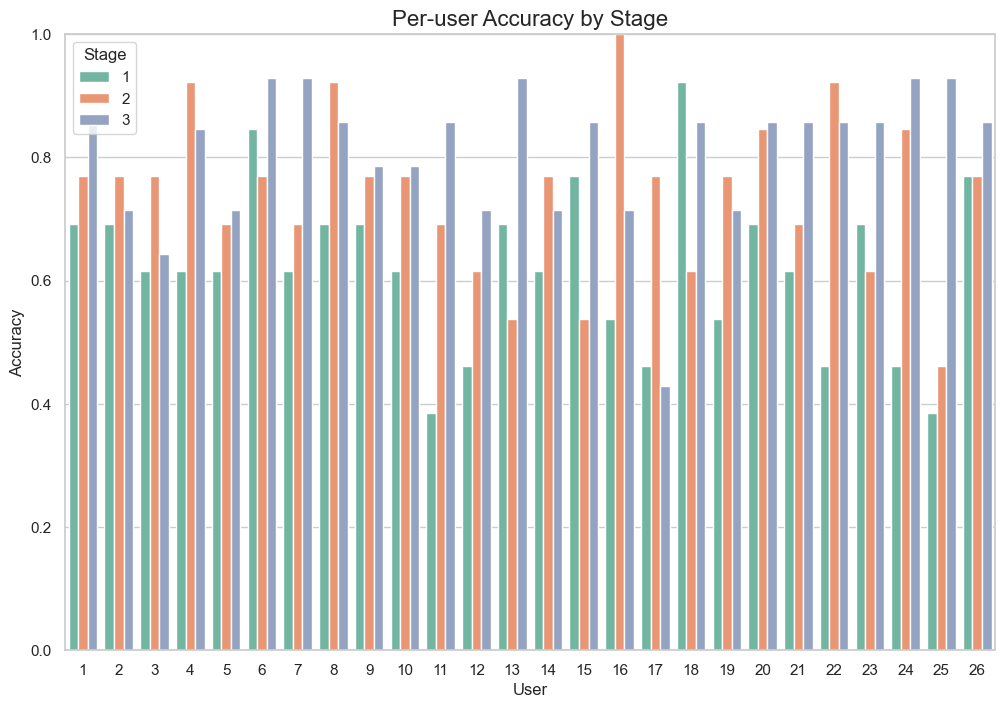

In [57]:
plt.figure(figsize=(12,8))

sns.barplot(
    data=segment_eval_df,
    x="User", y="Accuracy",
    hue="Stage",
    palette="Set2"
)

plt.title("Per-user Accuracy by Stage", fontsize=16)
plt.ylim(0,1)
plt.show()


   Stage      mean       sem
0      1  0.621302  0.026276
1      2  0.742604  0.025223
2      3  0.807270  0.022299


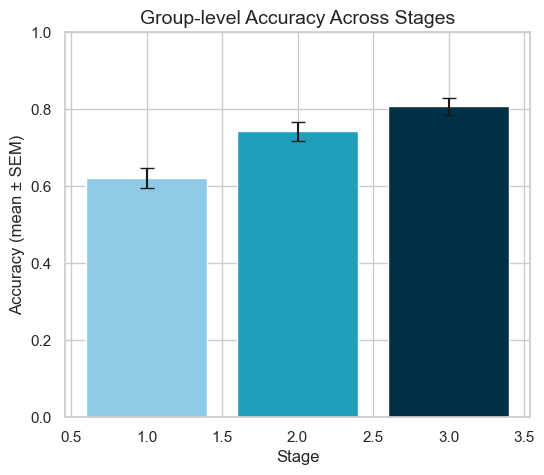

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

group_acc = (
    segment_eval_df.groupby("Stage")["Accuracy"]
          .agg(["mean", "sem"])
          .reset_index()
)

print(group_acc)

plt.figure(figsize=(6,5))

plt.bar(
    group_acc["Stage"],
    group_acc["mean"],
    yerr=group_acc["sem"],
    capsize=5,
    color=["#8ecae6", "#219ebc", "#023047"]
)

plt.xlabel("Stage", fontsize=12)
plt.ylabel("Accuracy (mean ± SEM)", fontsize=12)
plt.title("Group-level Accuracy Across Stages", fontsize=14)
plt.ylim(0, 1)

#for i, val in enumerate(group_acc["mean"]):
    #plt.text(group_acc["Stage"][i], val + 0.02, f"{val:.2f}", 
             #ha='center', fontsize=10)

plt.show()


In [59]:
acc_pivot = segment_eval_df.pivot(index="User", columns="Stage", values="Accuracy")

from scipy.stats import shapiro

print("1 vs 2:", shapiro(acc_pivot[2] - acc_pivot[1]))
print("2 vs 3:", shapiro(acc_pivot[3] - acc_pivot[2]))
print("1 vs 3:", shapiro(acc_pivot[3] - acc_pivot[1]))

1 vs 2: ShapiroResult(statistic=0.9627540464132917, pvalue=0.44862560299397997)
2 vs 3: ShapiroResult(statistic=0.9774548612051355, pvalue=0.8158507104348248)
1 vs 3: ShapiroResult(statistic=0.9333328185649573, pvalue=0.09305464326573694)


In [60]:
from scipy.stats import ttest_rel

acc1 = acc_pivot[1]
acc2 = acc_pivot[2]
acc3 = acc_pivot[3]

print("Stage1 vs Stage2:", ttest_rel(acc1, acc2))
print("Stage2 vs Stage3:", ttest_rel(acc2, acc3))
print("Stage1 vs Stage3:", ttest_rel(acc1, acc3))

Stage1 vs Stage2: TtestResult(statistic=-3.215315440595809, pvalue=0.0035789913793227227, df=25)
Stage2 vs Stage3: TtestResult(statistic=-1.7514435774716215, pvalue=0.09213099624227197, df=25)
Stage1 vs Stage3: TtestResult(statistic=-6.221146293712991, pvalue=1.6567085236750853e-06, df=25)


In [64]:
import pandas as pd
import numpy as np

df = fixed_segment_df.copy()

# 只保留 6 个核心 weight
core_weights = ["w_ev", "w_p", "w_r", "w_reg", "w_dis", "w_u"]

strategy_map = {
    "w_ev":  "Value-driven",
    "w_p":   "Preference-driven",
    "w_r":   "Risk-driven",
    "w_reg": "Regret-driven",
    "w_dis": "Disappointment-driven",
    "w_u":   "Uncertainty-driven",
}

def find_strategy(row):
    w = row[core_weights]
    max_w = w.abs().idxmax()
    return strategy_map[max_w]

df["Strategy"] = df.apply(find_strategy, axis=1)

print(df.head())

   User  Stage      w_ev       w_p       w_r     w_reg     w_dis       w_u  \
0     1      1 -0.849036  0.199191 -1.042186 -0.000010  0.000034  0.000051   
1     1      2 -1.430781 -0.086074 -2.391582  0.006265  0.004435 -0.003832   
2     1      3  0.626267  0.094953 -0.055457 -0.000010 -0.000025  0.000022   
3     2      1 -1.292449 -0.001589 -1.405078 -0.000081 -0.000507  0.002571   
4     2      2 -1.391467 -0.000010 -1.859921 -0.000042 -0.000052 -0.000029   

          b  beta      Strategy  
0  0.000054  10.0   Risk-driven  
1 -0.004242  10.0   Risk-driven  
2  0.000007  10.0  Value-driven  
3 -0.000597  10.0   Risk-driven  
4 -0.000055  10.0   Risk-driven  


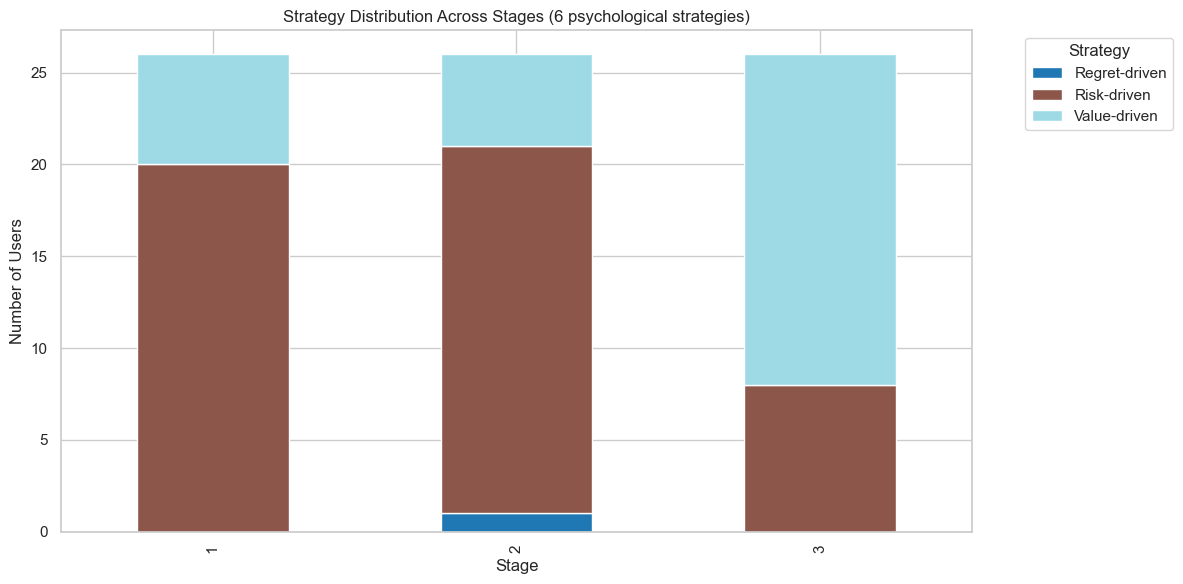

In [65]:
import matplotlib.pyplot as plt

df_group = df.groupby(["Stage","Strategy"]).size().reset_index(name="Count")

pivot_df = df_group.pivot(index="Stage", columns="Strategy", values="Count").fillna(0)

pivot_df.plot(
    kind="bar", stacked=True, figsize=(12,6),
    colormap="tab20"
)

plt.title("Strategy Distribution Across Stages (6 psychological strategies)")
plt.xlabel("Stage")
plt.ylabel("Number of Users")
plt.legend(title="Strategy", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [66]:
import plotly.graph_objects as go

# 从 df 中获取策略
df_s = df[["User","Stage","Strategy"]]

# 构建 1→2 和 2→3 的映射
trans_12 = df_s[df_s["Stage"]==1].merge(
    df_s[df_s["Stage"]==2], on="User", suffixes=("_1","_2")
)

trans_23 = df_s[df_s["Stage"]==2].merge(
    df_s[df_s["Stage"]==3], on="User", suffixes=("_2","_3")
)

# 全部策略名称
strategies = [
    "Value-driven",
    "Preference-driven",
    "Risk-driven",
    "Regret-driven",
    "Disappointment-driven",
    "Uncertainty-driven"
]

# 给节点编号
node_labels = []
node_to_id = {}

# Stage 1 节点
for s in strategies:
    node_to_id[f"1_{s}"] = len(node_labels)
    node_labels.append(f"S1: {s}")

# Stage 2 节点
for s in strategies:
    node_to_id[f"2_{s}"] = len(node_labels)
    node_labels.append(f"S2: {s}")

# Stage 3 节点
for s in strategies:
    node_to_id[f"3_{s}"] = len(node_labels)
    node_labels.append(f"S3: {s}")

# 计算链接（流量）
links_src = []
links_tgt = []
links_val = []

# 1→2
for s1 in strategies:
    for s2 in strategies:
        count = ((trans_12["Strategy_1"]==s1) & (trans_12["Strategy_2"]==s2)).sum()
        if count > 0:
            links_src.append(node_to_id[f"1_{s1}"])
            links_tgt.append(node_to_id[f"2_{s2}"])
            links_val.append(count)

# 2→3
for s2 in strategies:
    for s3 in strategies:
        count = ((trans_23["Strategy_2"]==s2) & (trans_23["Strategy_3"]==s3)).sum()
        if count > 0:
            links_src.append(node_to_id[f"2_{s2}"])
            links_tgt.append(node_to_id[f"3_{s3}"])
            links_val.append(count)

# 绘制 Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,
        thickness=18,
        line=dict(color="black", width=0.5),
        label=node_labels
    ),
    link=dict(
        source=links_src,
        target=links_tgt,
        value=links_val
    )
)])

fig.update_layout(title_text="Strategy Transitions Across Stages", font_size=12)
fig.write_html("sankey.html")

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

weights = ["w_ev", "w_p", "w_r", "w_reg", "w_dis", "w_u"]

# pivot: rows = User, columns = (weight, stage)
piv = fixed_segment_df.pivot(index="User", columns="Stage", values=weights)

# 计算 sign：+1 / -1 / 0
sign_piv = piv.apply(np.sign)
sign_piv.head()

w_ev            w_p            w_r           w_reg           w_dis       \
Stage    1    2    3    1    2    3    1    2    3     1    2    3     1    2   
User                                                                            
1     -1.0 -1.0  1.0  1.0 -1.0  1.0 -1.0 -1.0 -1.0  -1.0  1.0 -1.0   1.0  1.0   
2     -1.0 -1.0  1.0 -1.0 -1.0 -1.0 -1.0 -1.0  1.0  -1.0 -1.0 -1.0  -1.0 -1.0   
3     -1.0 -1.0  1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  -1.0 -1.0 -1.0  -1.0 -1.0   
4     -1.0 -1.0  1.0  1.0 -1.0 -1.0 -1.0 -1.0 -1.0   1.0  1.0 -1.0   1.0  1.0   
5     -1.0 -1.0  1.0 -1.0 -1.0  1.0 -1.0 -1.0  1.0  -1.0 -1.0  1.0  -1.0 -1.0   

            w_u            
Stage    3    1    2    3  
User                       
1     -1.0  1.0 -1.0  1.0  
2     -1.0  1.0 -1.0  1.0  
3      1.0 -1.0 -1.0 -1.0  
4     -1.0 -1.0  1.0  1.0  
5      1.0  1.0  1.0 -1.0

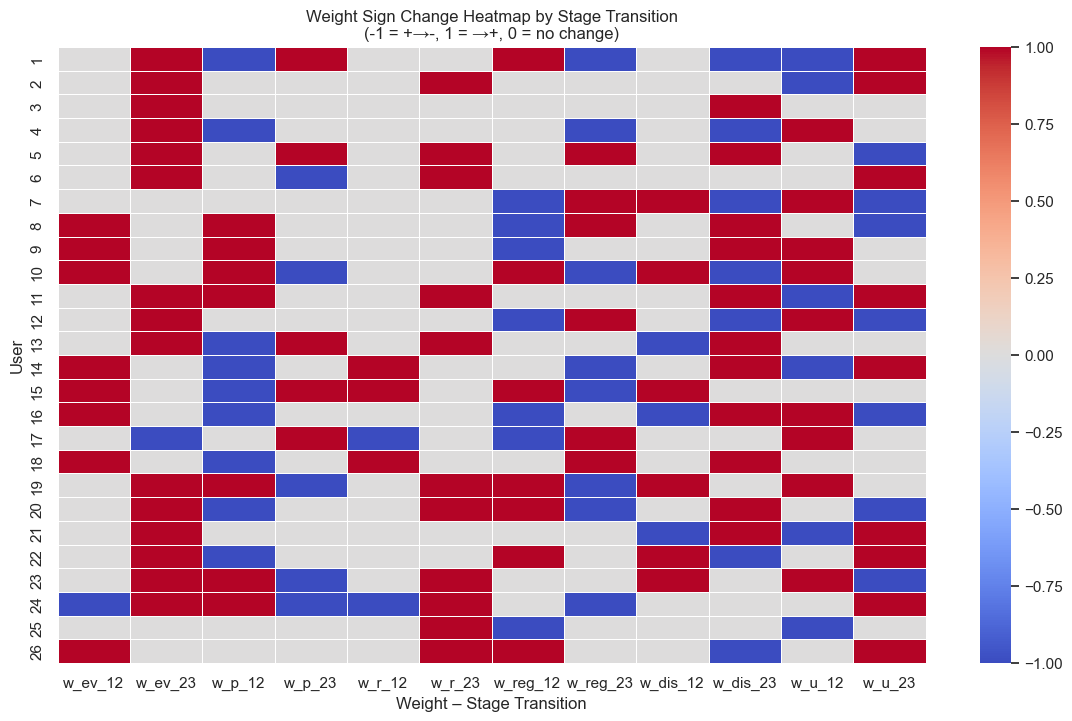

In [68]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

weights = ["w_ev", "w_p", "w_r", "w_reg", "w_dis", "w_u"]

piv = fixed_segment_df.pivot(index="User", columns="Stage", values=weights)

# piv.columns 是 MultiIndex： (weight, stage) or (stage, weight)
# 我们要强制变成 (weight, stage)

# 强制确保 columns 层级为 (weight, stage)
# 首先识别出列的层级名字
level0, level1 = piv.columns.levels

if weights[0] in level0:
    # (weight, stage) 正常
    piv_ws = piv
else:
    # (stage, weight) → swap
    piv_ws = piv.swaplevel(0, 1, axis=1)

# 确保排序（按 weight，再按 stage）
piv_ws = piv_ws.sort_index(axis=1, level=[0,1])

# 取 sign
sign_ws = piv_ws.apply(np.sign)

# 对每个 weight 分别计算 Stage 间变化
change_blocks = []

for w in weights:
    sub = sign_ws[w]   # columns are [1,2,3]

    diff = pd.DataFrame(index=sub.index)
    diff[f"{w}_12"] = (sub[2] - sub[1]) / 2     # Stage2 vs Stage1
    diff[f"{w}_23"] = (sub[3] - sub[2]) / 2     # Stage3 vs Stage2

    change_blocks.append(diff)

# 合并
sign_change = pd.concat(change_blocks, axis=1)

# 画热图
plt.figure(figsize=(14, 8))
sns.heatmap(sign_change, cmap="coolwarm", center=0, linewidths=.5)
plt.title("Weight Sign Change Heatmap by Stage Transition\n(-1 = +→-, 1 = →+, 0 = no change)")
plt.xlabel("Weight – Stage Transition")
plt.ylabel("User")
plt.show()


<Figure size 1200x1000 with 0 Axes>

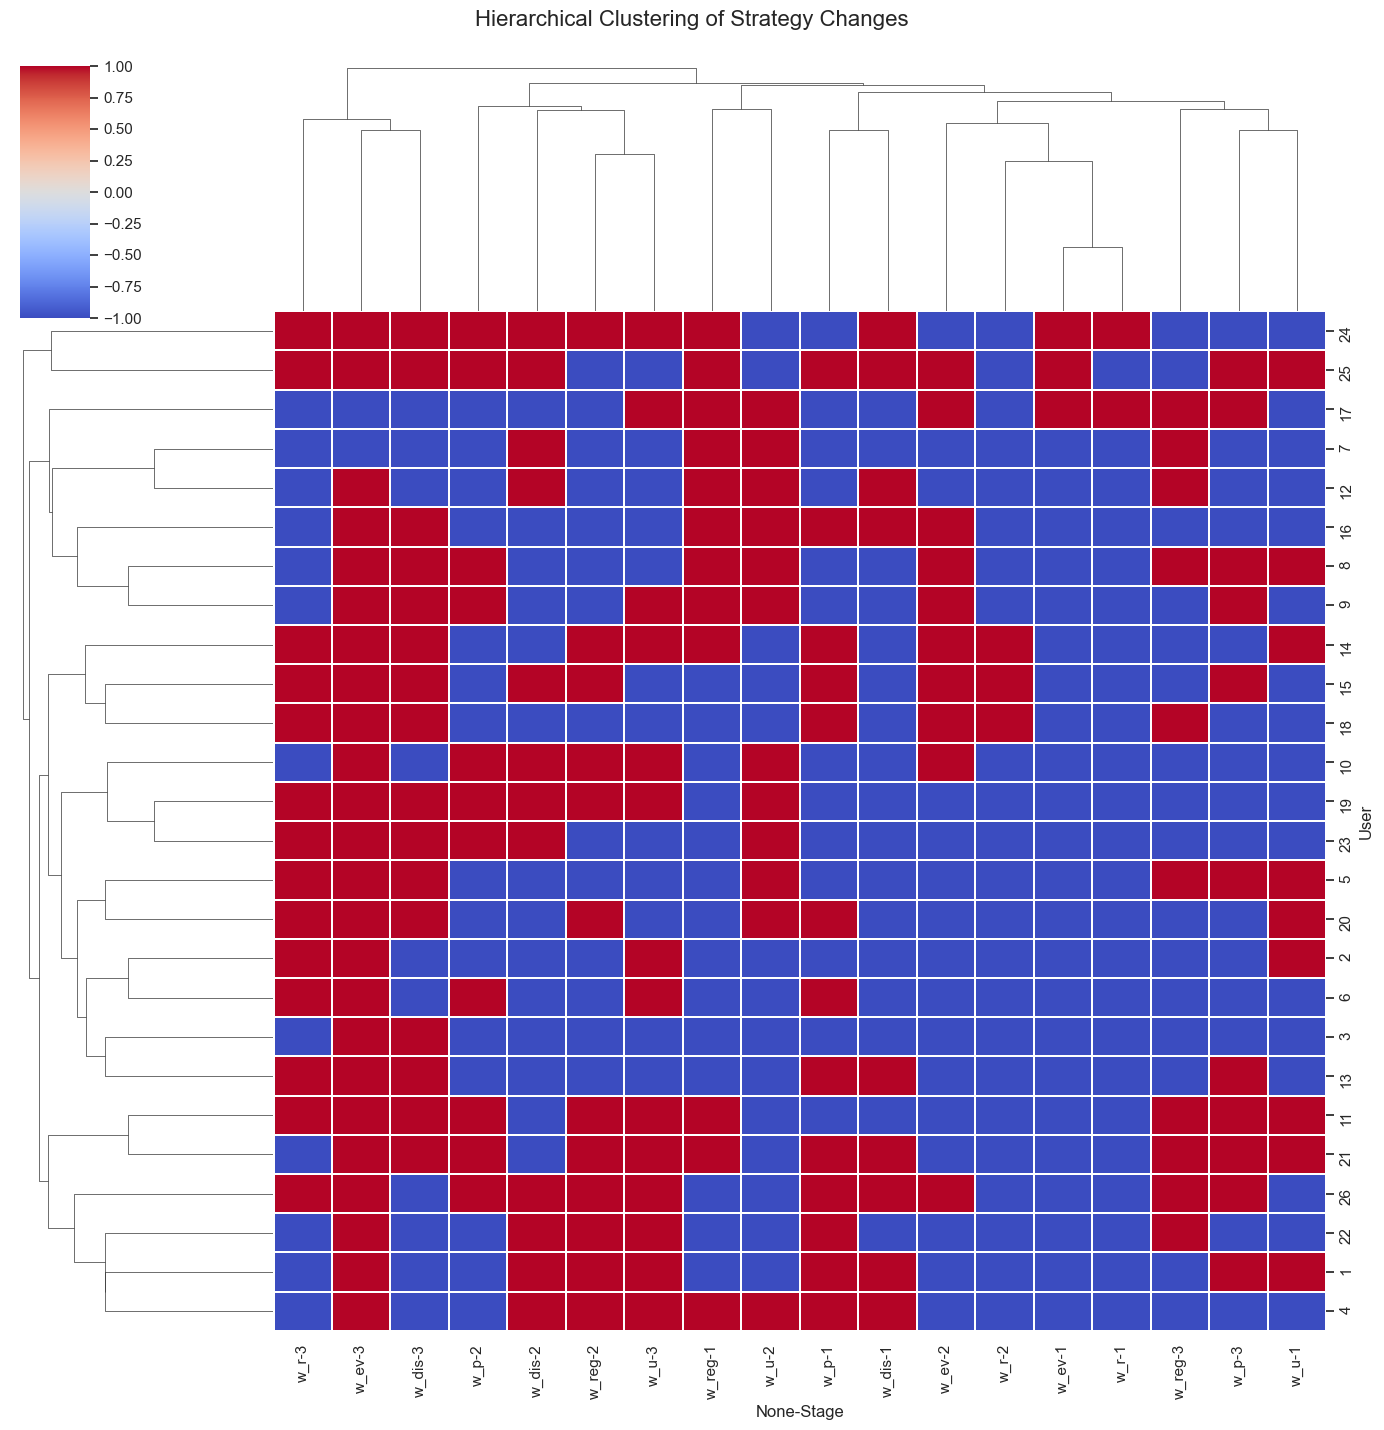

    User  Cluster
0     24        1
1     25        1
2     17        2
3      7        2
4     12        2
5     16        2
6      8        2
7      9        2
23    22        3
22    26        3
21    21        3
20    11        3
19    13        3
18     3        3
17     6        3
16     2        3
12    19        3
14     5        3
13    23        3
24     1        3
11    10        3
10    18        3
9     15        3
8     14        3
15    20        3
25     4        3


In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(12, 10))

cluster_grid = sns.clustermap(
    sign_piv,
    cmap="coolwarm",
    center=0,
    linewidths=0.3,
    figsize=(14, 14),
    col_cluster=True,   # 对权重类别聚类
    row_cluster=True    # 对参与者聚类
)

plt.suptitle("Hierarchical Clustering of Strategy Changes", y=1.02, fontsize=16)
plt.show()

# clustergrid 对象里有聚类结果：
row_order = cluster_grid.dendrogram_row.reordered_ind
labels = cluster_grid.dendrogram_row.linkage

# 生成 cluster 标签
from scipy.cluster.hierarchy import fcluster
cluster_labels = fcluster(labels, t=3, criterion='maxclust')

cluster_df = pd.DataFrame({
    "User": sign_piv.index[row_order],
    "Cluster": cluster_labels[row_order]
})

cluster_df = cluster_df.sort_values("Cluster")
print(cluster_df)

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

strategy_labels = ["w_ev", "w_p", "w_r", "w_reg", "w_dis", "w_u"]

stage1_df = df[ df["Stage"] == 1 ].reset_index(drop=True)
stage2_df = df[ df["Stage"] == 2 ].reset_index(drop=True)
stage3_df = df[ df["Stage"] == 3 ].reset_index(drop=True)

stage1_df, stage2_df, stage3_df

(    User  Stage      w_ev       w_p       w_r         w_reg         w_dis  \
 0      1      1 -0.849036  0.199191 -1.042186 -1.000842e-05  3.397442e-05   
 1      2      1 -1.292449 -0.001589 -1.405078 -8.117313e-05 -5.070418e-04   
 2      3      1 -0.831829 -0.000075 -0.867537 -3.950362e-05 -1.391169e-06   
 3      4      1 -1.045734  0.030099 -1.100192  2.184631e-02  2.587444e-02   
 4      5      1 -1.794388 -0.000006 -1.953012 -7.248621e-05 -8.819598e-05   
 5      6      1 -0.977876  0.021208 -1.059395 -2.088456e-02 -1.457124e-02   
 6      7      1 -0.307184 -0.000039 -0.536338  1.111652e-05 -4.580172e-05   
 7      8      1 -0.823382 -0.005440 -0.852525  2.887788e-02 -7.404733e-04   
 8      9      1 -0.585849 -0.004471 -0.727086  5.031857e-03 -7.556811e-03   
 9     10      1 -0.302811 -0.000028 -0.324539 -3.183128e-05 -2.326476e-05   
 10    11      1 -0.527068 -0.002474 -0.585435  2.036177e-04 -9.795421e-04   
 11    12      1 -0.513162 -0.000005 -0.570785  1.998786e-06  2.

In [71]:
def plot_stage_cluster(stage_df, stage_num, k=3):
    """
    对某个阶段的用户策略参数进行聚类并绘制 PCA 2D 图
    """
    # 取 6 个策略参数
    X = stage_df[strategy_labels].values

    # 标准化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # KMeans 聚类
    kmeans = KMeans(n_clusters=k, random_state=0)
    cluster_labels = kmeans.fit_predict(X_scaled)

    # 保存结果
    stage_df["Cluster"] = cluster_labels

    # PCA 降维到 2D
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # 画图
    plt.figure(figsize=(8, 6))
    colors = ["red", "blue", "green", "orange", "purple"]

    for i in range(k):
        pts = X_pca[cluster_labels == i]
        plt.scatter(pts[:, 0], pts[:, 1], 
                    label=f"Cluster {i}", 
                    s=80, alpha=0.75, color=colors[i % len(colors)])
        
    for idx, row in stage_df.iterrows():
        user_id = int(row["User"])
        x, y = X_pca[idx, 0], X_pca[idx, 1]
        plt.text(x + 0.02, y + 0.02, str(user_id), fontsize=9)

    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title(f"Strategy Clusters — Stage {stage_num}")
    plt.legend()
    plt.grid(True)
    plt.show()

    return stage_df

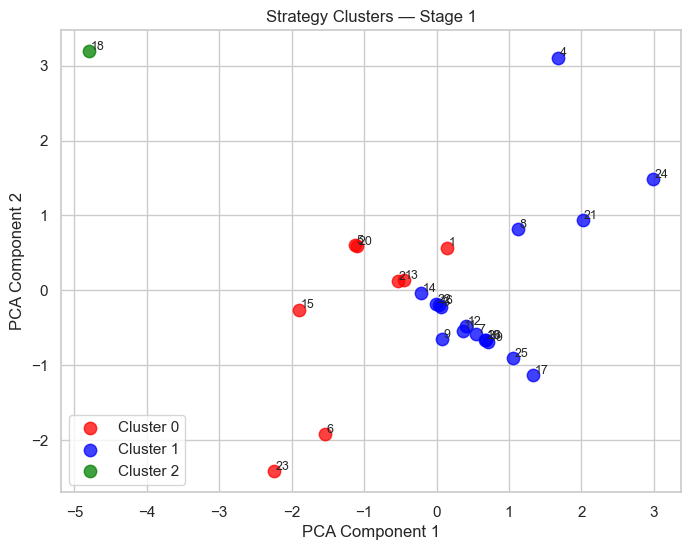

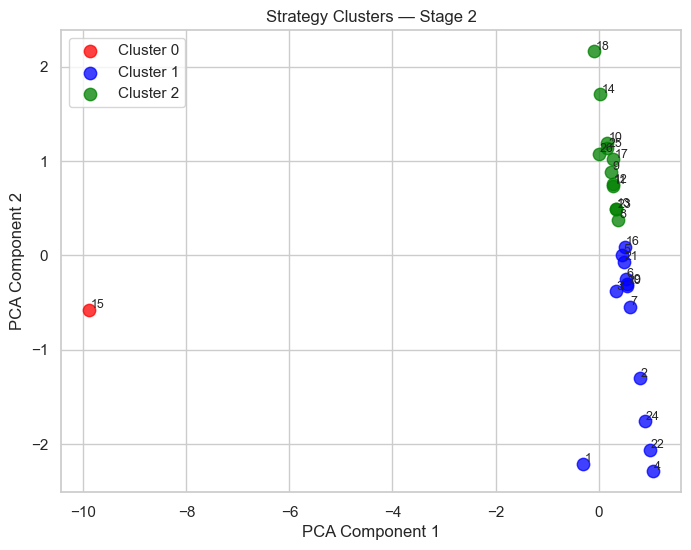

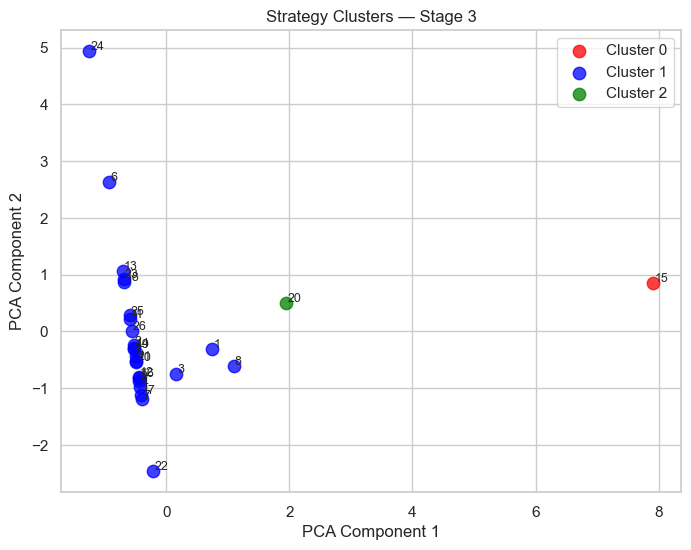

In [72]:
stage1_df = plot_stage_cluster(stage1_df, stage_num=1, k=3)
stage2_df = plot_stage_cluster(stage2_df, stage_num=2, k=3)
stage3_df = plot_stage_cluster(stage3_df, stage_num=3, k=3)

In [73]:
print(f'stage1:{stage1_df.groupby("Cluster")[strategy_labels].mean()}')
print(f'stage2:{stage2_df.groupby("Cluster")[strategy_labels].mean()}')
print(f'stage3:{stage3_df.groupby("Cluster")[strategy_labels].mean()}')

stage1:             w_ev       w_p       w_r     w_reg     w_dis       w_u
Cluster                                                            
0       -1.364278  0.026686 -1.508049 -0.008004 -0.004660 -0.000640
1       -0.483120  0.002267 -0.544873  0.006200  0.002716  0.000480
2       -4.956252  0.000135 -5.130423 -0.000147 -0.000144 -0.000026
stage2:             w_ev       w_p       w_r     w_reg     w_dis       w_u
Cluster                                                            
0        0.689445 -0.175779  0.464683  0.689453  0.190196 -0.190834
1       -0.854285 -0.007310 -1.817917  0.000480  0.000141 -0.001170
2        0.158222 -0.000035 -0.251443 -0.000065 -0.000298 -0.000955
stage3:             w_ev       w_p       w_r     w_reg     w_dis       w_u
Cluster                                                            
0        0.711383  0.124322  0.026091 -0.052518  0.174715 -0.031558
1        0.839763  0.004410  0.241036  0.000052  0.000271 -0.001120
2        0.872035 -0.046290